In [1]:
import os
import pathlib
# move caching off of afs
log_dir = "/lfs/1/sabri/data/robustnessgym/datasets/"
os.environ['HF_HOME'] = os.path.join(log_dir, "hugging_face/cache/") # source: https://github.com/huggingface/transformers/issues/8703
os.makedirs(log_dir, exist_ok=True)
import robustnessgym as rg
rg.Dataset.logdir = pathlib.Path(log_dir)

[2021-03-31 09:04:03,403][INFO][root:41] :: Logging initialized.


In [2]:
import cytoolz as tz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import pickle

from scipy.special import logsumexp
from itertools import product
from robustnessgym.core.model import Model, HuggingfaceModel
from robustnessgym import BinarySentiment
from tqdm.auto import tqdm
from types import SimpleNamespace

In [3]:
np.set_printoptions(precision=2, suppress=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [4]:
imdb = rg.Dataset.load_dataset('imdb')

[2021-03-31 09:04:35,367][WARNING][datasets.builder:512] :: Reusing dataset imdb (/lfs/1/sabri/data/robustnessgym/datasets/hugging_face/cache/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)
[2021-03-31 09:04:35,572][INFO][robustnessgym.core.dataformats.inmemory:87] :: Created `InMemoryDataset` with 25000 rows and 2 columns.
[2021-03-31 09:04:35,580][INFO][root:133] :: Added column `index` with length `25000`.
[2021-03-31 09:04:35,663][INFO][robustnessgym.core.dataformats.inmemory:87] :: Created `InMemoryDataset` with 25000 rows and 2 columns.
[2021-03-31 09:04:35,671][INFO][root:133] :: Added column `index` with length `25000`.
[2021-03-31 09:04:35,829][INFO][robustnessgym.core.dataformats.inmemory:87] :: Created `InMemoryDataset` with 50000 rows and 2 columns.
[2021-03-31 09:04:35,843][INFO][root:133] :: Added column `index` with length `50000`.


In [5]:
sentiment140 = rg.Dataset.load_dataset("sentiment140")

[2021-03-31 09:04:36,692][WARNING][datasets.builder:512] :: Reusing dataset sentiment140 (/lfs/1/sabri/data/robustnessgym/datasets/hugging_face/cache/datasets/sentiment140/sentiment140/1.0.0/9fe1c0ce3319c47cc65ff7e49aac6c34d9c050ab1432988c104b3b275e360f3f)
[2021-03-31 09:04:45,349][INFO][robustnessgym.core.dataformats.inmemory:87] :: Created `InMemoryDataset` with 1600000 rows and 5 columns.
[2021-03-31 09:04:45,779][INFO][root:133] :: Added column `index` with length `1600000`.
[2021-03-31 09:04:45,800][INFO][robustnessgym.core.dataformats.inmemory:87] :: Created `InMemoryDataset` with 498 rows and 5 columns.
[2021-03-31 09:04:45,801][INFO][root:133] :: Added column `index` with length `498`.


In [6]:
# This is still a bit janky in RG, lmk if there's trouble here
model = Model.huggingface(identifier='textattack/bert-base-uncased-imdb', is_classifier=True)
model.task = BinarySentiment()

In [7]:
def predict_dataset(model, dataset, input_columns, batch_size=10, batches=None):
    predictions = []
    for i, batch in tqdm(enumerate(dataset.batch(batch_size))):
        predictions.append(model.predict_batch(batch=batch, input_columns=input_columns))
        if i == batches:
            break
    return {k: list(tz.concat([p[k] for p in predictions])) for k in predictions[0].keys()}

# Sentiment 140

In [26]:
if os.path.exists('textattack-bert-base-uncased-imdb_sentiment140_predictions.pkl') and False:
    sentiment140_predictions = pickle.load(
        open('textattack-bert-base-uncased-imdb_sentiment140_predictions.pkl', 'rb')
    )
else:
    sentiment140_predictions = predict_dataset(model, sentiment140['test'], ['text'], batch_size=10)
    pickle.dump(
        sentiment140_predictions,  
        open('textattack-bert-base-uncased-imdb_sentiment140_predictions.pkl', 'wb')
    )

In [11]:
def evaluate_sentiment140(predictions, labels):
    preds = np.array(predictions['pred'])
    sentiment140_not_neutral_indices = np.where(labels != 2)[0]
    correct = preds[sentiment140_not_neutral_indices] == np.array(labels[sentiment140_not_neutral_indices]/4.).astype(int)
    return {
        'correct': correct.astype(int), 
        'accuracy': np.mean(correct)
    }
    

In [28]:
sentiment140_labels = np.array(sentiment140['test']['sentiment'])
sentiment140_not_neutral_indices = np.where(sentiment140_labels != 2)[0]
sentiment140_eval = evaluate_sentiment140(sentiment140_predictions, sentiment140_labels)

# IMDB

In [21]:
if os.path.exists('textattack-bert-base-uncased-imdb_imdb_predictions.pkl'):
    imdb_predictions = pickle.load(
        open('textattack-bert-base-uncased-imdb_imdb_predictions.pkl', 'rb')
    )
else:
    imdb_predictions = predict_dataset(model, imdb['test'], ['text'], batch_size=10)
    pickle.dump(
        imdb_predictions,  
        open('textattack-bert-base-uncased-imdb_imdb_predictions.pkl', 'wb')
    )

In [14]:
def evaluate_imdb(predictions, labels):
    preds = np.array(predictions['pred'])
    
    correct = (preds == labels).astype(int)
    return {
        'correct': correct,
        'accuracy': np.mean(correct),
    }

In [29]:
imdb_labels = np.array(imdb['test']['label'])
imdb_eval = evaluate_imdb(imdb_predictions, imdb_labels)

# Simple Slices

In [30]:
"""Slices for entropy, prediction."""

def calc_entropy(probs):
    return (- probs * np.log(probs)).sum(axis=1)

def entropy_slice(probs):
    entropy = calc_entropy(probs)
    intervals = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7)]
    return np.array([[t[0] <= e <= t[1] for t in intervals] for e in entropy]).astype(int)

def prediction_slice(preds, n_classes=2):
    return np.eye(n_classes)[preds].astype(int)

def task_agnostic_slices(probs, preds):
    return SimpleNamespace(
        slices=np.concatenate([
            entropy_slice(probs),
            prediction_slice(preds),
            ], axis=1
        ),
        n=(8, 2),
    )


In [31]:
imdb_tas = \
task_agnostic_slices(
    probs=np.stack(imdb_predictions['probs']),
    preds=imdb_predictions['pred'],
)

sentiment140_tas = \
task_agnostic_slices(
    probs=np.stack(sentiment140_predictions['probs']),
    preds=sentiment140_predictions['pred'],
)

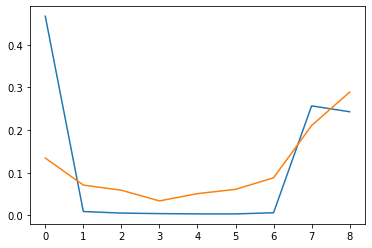

In [32]:
# Plot the distributions of the slices
plt.plot(imdb_tas.slices.sum(axis=0)/imdb_tas.slices.sum())
plt.plot(sentiment140_tas.slices.sum(axis=0)/sentiment140_tas.slices.sum())

# Mandoline

In [33]:
def Phi(D, edge_list):
    if edge_list is not None:
        pairwise_terms = D[np.arange(len(D)), edge_list[:, 0][:, np.newaxis]].T * D[np.arange(len(D)), edge_list[:, 1][:, np.newaxis]].T
        return np.concatenate([D, pairwise_terms], axis=1)
    else:
        return D
    
def log_partition_ratio(x, Phi_D_src, n_src):
    return np.log(n_src) - logsumexp(Phi_D_src.dot(x))

def solver(D_src, D_tgt, edge_list):
    D_src, D_tgt = np.copy(D_src), np.copy(D_tgt)
    if np.min(D_src) == 0:
        D_src[D_src == 0] = -1
        D_tgt[D_tgt == 0] = -1
    # Edge list encoding dependencies between gs
    if edge_list is not None:
        edge_list = np.array(edge_list)
    
    # Create the potential matrices
    Phi_D_tgt, Phi_D_src = Phi(D_tgt, edge_list), Phi(D_src, edge_list)
    
    # Number of examples
    n_src, n_tgt = Phi_D_src.shape[0], Phi_D_tgt.shape[0]
    
    def f(x):
        obj = Phi_D_tgt.dot(x).sum() - n_tgt * logsumexp(Phi_D_src.dot(x))
        return -obj
    
    # Solve
    opt = scipy.optimize.minimize(f, np.random.randn(Phi_D_tgt.shape[1]), method='BFGS')
    
    return SimpleNamespace(
        opt=opt, 
        Phi_D_src=Phi_D_src, 
        Phi_D_tgt=Phi_D_tgt, 
        n_src=n_src, 
        n_tgt=n_tgt, 
        edge_list=edge_list)

def log_density_ratio(D, solved):
    Phi_D = Phi(D, None)
    return Phi_D.dot(solved.opt.x) + log_partition_ratio(solved.opt.x, solved.Phi_D_src, solved.n_src)

def get_k_most_unbalanced_gs(D_src, D_tgt, k):
    marginal_diff = np.abs(D_src.mean(axis=0) - D_tgt.mean(axis=0))
    differences = np.sort(marginal_diff)[-k:]
    indices = np.argsort(marginal_diff)[-k:]
    return list(indices), list(differences)

def weighted_estimator(weights, empirical_mat):
    if weights is None:
        return np.mean(empirical_mat, axis=0)
    return np.sum(weights[:, np.newaxis] * empirical_mat, axis=0)

def run_estimation_experiment(D_src, D_tgt, indices, edge_list, empirical_mat_list_src, empirical_mat_list_tgt):
    """
    Main entry point to run an experiment with Mandoline.
    
    D_src: binary source matrix (n_s x d) with 0/1 entries
    D_tgt: binary target matrix (n_t x d) with 0/1 entries
    indices: list of integers used to restrict the procedure to some subset of the columns in D_src, D_tgt
    edge_list: edge pairs (e.g. [(0, 1)]) that indicate correlation in the graphical model structure
    empirical_mat_list_src: list of source matrices for which reweighted means will be computed
    empirical_mat_list_tgt: list of target matrices for which direct means will be computed
    """
    assert len(empirical_mat_list_src) == len(empirical_mat_list_tgt)
    # Run the solver
    solved = solver(
        D_src[:, indices] if indices is not None else D_src, 
        D_tgt[:, indices] if indices is not None else D_tgt, 
        edge_list,
    )
    # Compute the weights on the source dataset
    density_ratios = np.e ** log_density_ratio(solved.Phi_D_src, solved)
    weights = density_ratios/np.sum(density_ratios)
    
    all_estimates = []
    for mat_src, mat_tgt in zip(empirical_mat_list_src, empirical_mat_list_tgt):
        # Estimates is a 1-D array of estimates for each mat e.g. each mat can correspond to a model's (n x 1) error matrix
        weighted_estimates = weighted_estimator(weights, mat_src)
        source_estimates = weighted_estimator(np.ones(solved.n_src)/solved.n_src, mat_src)
        target_estimates = weighted_estimator(np.ones(solved.n_tgt)/solved.n_tgt, mat_tgt)
        
        all_estimates.append(SimpleNamespace(weighted=weighted_estimates, source=source_estimates, target=target_estimates))
        
    return SimpleNamespace(all_estimates=all_estimates, solved=solved, weights=weights, indices=indices)
    
def diagnostics(results, D_src, D_tgt):
    print(results.all_estimates)
    print("Source | Weighted Source | Target marginals for picked g_is (should match ideally)")
    print(weighted_estimator(None, D_src[:, results.indices]), weighted_estimator(results.weights, D_src[:, results.indices]), weighted_estimator(None, D_tgt[:, results.indices]))
    plt.plot(np.sort(results.weights))
    plt.show()
    
def effective_sample_size(weights):
    n = weights.shape[0]
    return n * (weights.mean())**2 / (weights**2).mean()

def get_correlation_structure(m, top_k=None, thresh=None, min_thresh=0.1, lmbda=0.1):
    # Compute the inverse covariance matrix
    inv_cov = np.linalg.inv(np.dot(m.T, m)/m.shape[0] + np.eye(m.shape[1]) * lmbda)
    
    # Absolute values
    inv_cov = np.abs(inv_cov)
    
    # Set diagonal values to 0.
    inv_cov[np.arange(inv_cov.shape[0]), np.arange(inv_cov.shape[0])] = 0.
    
    # Create an adjacency matrix
    inv_cov_adj = np.zeros_like(inv_cov)
    
    if top_k:
        # Indices for top-k values
        top_k_entries = np.unravel_index(np.argsort(inv_cov.ravel())[-top_k * 2:], inv_cov.shape)
        inv_cov_adj[top_k_entries] = 1
        inv_cov_adj[inv_cov <= min_thresh] = 0.
    else:
        inv_cov_adj[inv_cov > thresh] = 1
    inv_cov_adj[np.arange(inv_cov_adj.shape[0]), np.arange(inv_cov_adj.shape[0])] = 0
    
    # Figure out the edges
    edges = np.array([t for t in zip(*np.where(inv_cov_adj)) if t[0] < t[1]])
    
    return edges

In [34]:
exp_imdb_to_sentiment140 = run_estimation_experiment(
    D_src=imdb_tas.slices,
    D_tgt=sentiment140_tas.slices[sentiment140_not_neutral_indices],
    indices=None,
    edge_list=None,
    empirical_mat_list_src=[imdb_eval['correct'][:, np.newaxis]],
    empirical_mat_list_tgt=[sentiment140_eval['correct'][:, np.newaxis]]
)

In [35]:
exp_imdb_to_sentiment140.all_estimates

[namespace(weighted=array([0.71]), source=array([0.93]), target=array([0.76]))]

In [36]:
weighted = np.array([
    exp_imdb_to_sentiment140.all_estimates[0].weighted,
])

source = np.array([
    exp_imdb_to_sentiment140.all_estimates[0].source,
])

target = np.array([
    exp_imdb_to_sentiment140.all_estimates[0].target,
])

In [38]:
df = pd.DataFrame(
    np.concatenate([source, weighted, target], axis=1), 
    columns=['Source', 'Weighted', 'Target'],
)
df['Shift'] = [ 
    'IMDB -> Sentiment 140 Test',  
]
df

,Source,Weighted,Target,Shift
0,0.93028,0.708924,0.75766,IMDB -> Sentiment 140 Test
